## Ensuring the NN shape outputs make sense

In [55]:
import tensorflow as tf
# import tensorflow_probabilities as tfp
import sys
sys.path.insert(0, '../')
from train_pg_f18 import build_mlp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
sy_ob_no = tf.placeholder(shape=[None, 5], name="ob", dtype=tf.float32)
output_size = 5
scope = 'yo'
hidden_size = 20
n_layers = 1

output = build_mlp(sy_ob_no,output_size,scope,n_layers,hidden_size)

In [5]:
print(output)
dummy_data = np.array([[.3,.7,.9,.6,.8]])
print(dummy_data.shape)

Tensor("yo/fully_connected_1/BiasAdd:0", shape=(?, 5), dtype=float32)
(1, 5)


In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # I couldn't really move this around, bc it cam after the optimizer. 
    output_preds = sess.run(output,feed_dict = {sy_ob_no:dummy_data})
    print (output_preds)

[[-0.53999096 -0.12600006  0.62857336  0.64132118  0.14903396]]


In [7]:
print(output_preds.shape)

(1, 5)


In [8]:
# samples = tf.multinomial([[0.4,0.5,0.1]],100000)
samples = tf.multinomial(tf.log([[4.0,5.0,1.0]]),100000)


with tf.Session() as sess:
    output = sess.run(samples)
unique, counts = np.unique(output, return_counts=True)
dict(zip(unique, counts))


{0: 40139, 1: 49968, 2: 9893}

In [9]:
tf.__version__


'1.0.0'

### Demonstration of how to sample from the normal distribution

In [78]:
mean_dim = [3,4]
std_dim = [1,4]

std_vals = np.random.rand(std_dim[0],std_dim[1])
mean_vals = np.random.rand(mean_dim[0],mean_dim[1])

mu = tf.placeholder(shape = mean_dim,dtype = tf.float32)
std = tf.placeholder(shape = std_dim,dtype = tf.float32)
samples_norm = tf.add(mu,tf.multiply(std,tf.random_normal(tf.shape(mu))))


discrete_tester = tf.squeeze(tf.multinomial(samples_norm,1),axis = 1)


with tf.Session() as sess:
    output = sess.run(samples_norm,feed_dict = {mu:mean_vals,std:std_vals})
    
    dt = sess.run(discrete_tester,feed_dict = {mu:mean_vals,std:std_vals})
    
#     output = sess.run(tf.shape(samples_norm))
# unique, counts = np.unique(output, return_counts=True)
# dict(zip(unique, counts))

print (output)

print('\n dt is ')
print(dt)
print(dt.shape)


[[ 1.37345386  0.30129188 -0.10639644 -0.06621715]
 [ 1.01591432  0.4846406   0.90930462  1.33892906]
 [ 0.53720313  0.58418894  0.21078295  0.0555799 ]]

 dt is 
[0 1 2]
(3,)


In [21]:
vect = tf.placeholder(shape = output.shape,dtype = tf.float32)
sm_out = tf.nn.softmax(vect)
# selected_out = sm_out[2][2]

chosen_actions = tf.constant([2,1,0])
indexer = tf.stack([tf.range(0,tf.shape(chosen_actions)[0],1), chosen_actions], axis = 1)
probs_of_chosen_actions = tf.gather_nd(sm_out,indexer)
log_prob = tf.log(probs_of_chosen_actions)
with tf.Session() as sess:
    sm_vect = sess.run(sm_out,feed_dict = {vect:output})
    
    print(sm_vect)
#     sm_vect_2 = sess.run(selected_out,feed_dict = {vect:output})
#     print(sm_vect_2)

#


[[ 0.1871317   0.16587     0.4783242   0.1686741 ]
 [ 0.12187979  0.23101066  0.42859444  0.21851519]
 [ 0.13118604  0.14960441  0.43545118  0.28375834]]


In [22]:
with tf.Session() as sess:
    print(sess.run(probs_of_chosen_actions,feed_dict = {vect:output}))
    print(sess.run(log_prob,feed_dict = {vect:output}))
    

[ 0.4783242   0.23101066  0.13118604]
[-0.73746651 -1.46529138 -2.0311389 ]


### Now I'm trying to choose the appropriate action from my softmaxed vector of probabilities
A for loop would be easy, but I think I need tf.gather_nd 

UGH, so I could either make a tensor like [[0,a0],[1,a1],[2,a2]] and then use gather_nd. or I could flatten my tensor
of softmax and then make my chosen action tensor [a0 a1 a2...] into [a_dim*0+a0 adim*1+a1 ... ]

AH! I need tf.stack

In [2]:
with tf.Session() as sess:
    p_CA = sess.run(p_of_chosen_actions,feed_dict = {vect:output})
    print(p_CA)

NameError: name 'p_of_chosen_actions' is not defined

## Now deal with the continuous case! Get the pdf(a_i) for each action component "i"

In [27]:
# x = tf.constant(5.0, shape=[5, 6])
x = output
w = tf.constant([0.0, 1.0, 2.0, 3.0])
xw = tf.multiply(w, x)
max_in_rows = tf.reduce_max(xw, 1)

sess = tf.Session()
print(sess.run(xw))
# ==> [[0.0, 5.0, 10.0, 15.0, 20.0, 25.0],
#      [0.0, 5.0, 10.0, 15.0, 20.0, 25.0],
#      [0.0, 5.0, 10.0, 15.0, 20.0, 25.0],
#      [0.0, 5.0, 10.0, 15.0, 20.0, 25.0],
#      [0.0, 5.0, 10.0, 15.0, 20.0, 25.0]]

print(sess.run(max_in_rows))
# ==> [25.0, 25.0, 25.0, 25.0, 25.0]

[[ 0.          0.21850783  2.55518436  0.70581532]
 [ 0.          0.72378755  2.68366957  2.00453758]
 [ 0.          0.26623872  2.66925383  2.71910143]]
[ 2.55518436  2.68366957  2.71910143]


In [80]:
import math as m
two_pi = tf.constant(2*m.pi,dtype = tf.float32)


diff_mat = mu #acting like this is a1-mu1
sigma_square = tf.square(std)

# with tf.Session() as sess:
#     print(sess.run(tf.divide(diff_mat,sigma_square),feed_dict={std:np.random.rand(std_dim[0],std_dim[1])}))
# one = tf.constant(1,dtype = tf.float23)
first_term = tf.divide(tf.cast(1,tf.float32),tf.sqrt(tf.multiply(two_pi,sigma_square)))
second_term = tf.exp(tf.negative(tf.divide(tf.square(diff_mat),tf.multiply(tf.cast(2,tf.float32),sigma_square))))
pdf_output = tf.multiply(first_term,second_term)

log_pdf = tf.log(pdf_output)
sy_logprob_n = tf.reduce_sum(log_pdf,1) 
with tf.Session() as sess:
    print(sess.run(sigma_square,feed_dict={std:std_vals}))
    print(sess.run(sy_logprob_n,feed_dict={std:std_vals, diff_mat:mean_vals}))



[[ 0.31127119  0.28142202  0.01284883  0.13900143]]
[ -0.65995139 -36.02285385  -1.82592762]


### Note we should test it by making a graph of the pdf of the normal dist!

And yep, it works in the multidimensional case!!!
Everything set to go.




(1, 100)


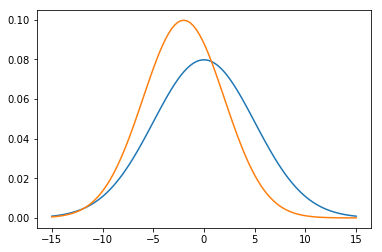

In [75]:
tester_shape = [2,100]
test_diff_mat = tf.placeholder(shape = tester_shape,dtype = tf.float32)
test_sigma_square = tf.placeholder(shape = tester_shape,dtype = tf.float32)

test_values_diff_mat = np.array([np.linspace(-15,15,tester_shape[1])])
test_values_diff_mat2 = np.array([np.linspace(-13,17,tester_shape[1])])
tvdm = np.concatenate((test_values_diff_mat,test_values_diff_mat2),axis = 0)

test_values_sigma_square = np.array(np.ones([1,100])*25)
test_values_sigma_square2 = np.array(np.ones([1,100])*16)
tvss = np.concatenate((test_values_sigma_square,test_values_sigma_square2),axis = 0)
print(test_values_sigma_square.shape)

test_first_term = tf.divide(tf.cast(1,tf.float32),tf.sqrt(tf.multiply(two_pi,test_sigma_square)))
test_second_term = tf.exp(tf.negative(tf.divide(tf.square(test_diff_mat),tf.multiply(tf.cast(2,tf.float32),test_sigma_square))))
test_pdf_output = tf.multiply(test_first_term,test_second_term)



with tf.Session() as sess:
#     to_plot = sess.run(test_pdf_output,feed_dict={test_sigma_square:test_values_sigma_square, test_diff_mat:test_values_diff_mat})
#     to_plot2 = sess.run(test_pdf_output,feed_dict={test_sigma_square:test_values_sigma_square2, test_diff_mat:test_values_diff_mat2})
    to_plot = sess.run(test_pdf_output,feed_dict={test_sigma_square:tvss, test_diff_mat:tvdm})


# plt.figure()
# plt.plot(test_values_diff_mat[0],to_plot[0])
# plt.plot(test_values_diff_mat[0],to_plot2[0])
# plt.show()

plt.figure()
plt.plot(test_values_diff_mat[0],to_plot[0])
plt.plot(test_values_diff_mat[0],to_plot[1])
plt.show()



## making the sum_of_reward

In [90]:
re_n = np.ones(shape = [3,4])
print(re_n)
gamma = 0.9
for re_path in re_n:
    print(np.sum([(gamma**j)*re_path[j] for j in range(len(re_path))]))

[[ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]
 [ 1.  1.  1.  1.]]
3.439
3.439
3.439


#### This shows that the double-nested list comprehension makes the reward to-go-vector

reward to go is first, and then total reward (with discounts too) is next print out

In [106]:
q_n = np.array([])
for re_single_path in re_n:
#     q_t = [(gamma**j)*re_single_path[j] for j in range(len(re_single_path))]
    q_t_vector = [np.sum([(gamma**i)*(re_single_path[j+i]) for i in range(len(re_single_path)-j)]) for j in range(len(re_single_path))] # Seems wrong, but i guess we sum this entire thing...
#     q_t_vector = [q_t for j in range(len(re_single_path))]
    q_n = np.append(q_n,q_t_vector)
    print(q_t)

print(q_n)
    

q_n = np.array([])
for re_single_path in re_n:
    q_t = np.sum([(gamma**j)*re_single_path[j] for j in range(len(re_single_path))])  # Seems wrong, but i guess we sum this entire thing...
    q_t_vector = [q_t for j in range(len(re_single_path))]
    q_n = np.append(q_n,q_t_vector)
print(q_n.shape)



3.439
3.439
3.439
[ 3.439  2.71   1.9    1.     3.439  2.71   1.9    1.     3.439  2.71   1.9
  1.   ]
(12,)


In [108]:
!ls

HW2 testing ground.ipynb                Untitled.ipynb
Homework 2 terminals and readouts.ipynb data


In [111]:
! python ../plot.py ../data/sb_no_rtg_dna_CartPole-v0_10-09-2019_17-26-03/ --value AverageReturn

Traceback (most recent call last):
  File "../plot.py", line 120, in <module>
    main()
  File "../plot.py", line 110, in main
    data += get_datasets(logdir)
  File "../plot.py", line 71, in get_datasets
    experiment_data = pd.read_table(log_path)
  File "/Users/matthewhunt/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py", line 646, in parser_f
    return _read(filepath_or_buffer, kwds)
  File "/Users/matthewhunt/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py", line 389, in _read
    parser = TextFileReader(filepath_or_buffer, **kwds)
  File "/Users/matthewhunt/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py", line 730, in __init__
    self._make_engine(self.engine)
  File "/Users/matthewhunt/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py", line 923, in _make_engine
    self._engine = CParserWrapper(self.f, **self.options)
  File "/Users/matthewhunt/anaconda/lib/python3.6/site-packages/pandas/io/parsers.py", line 1390, in __init__
    self